# M3 Metric Analysis

The tabular results of evaluating the M3 metric for extended object counts for the RGPS survey design.  All science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

First we need to load some of the configuration information for the metric simulation for future reference.

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
# Load definitions of science cases and extract the set of topical categories
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

## M3 Extended Object Metric

A number of science cases expressed an interest in observing as many targets as possible from a known catalog of objects. There are several examples of these, including Open and Globular Clusters, Star Forming Regions, Molecular Clouds/HII regions and Active Galactic Nuclei. The metrics to evaluate these cases are fundamentally the same - calculating the percentage (by area) of the target catalog to receive observations in the requested filters - the code was combined into a single metric which accepts different target catalogs of interest.

Note that not all proposals listing SFRs or clusters are so labeled, since some proposals aim to perform wide-area surveys in order to detect more clusters rather than to cover a catalog of known objects.

In [4]:
# Load the M3 metric results calculated for the entire known catalogs of the different types of object
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_combined_results.txt')

m3_results = Table.read(m3_results_file, format='ascii')
m3_results.pprint_all()

Survey_strategy Optic        Science_case       Science_code      Category        M3_%regions     M3_count
--------------- ----- ------------------------- ------------ ----------------- ------------------ --------
      wide_area  F129                  Paladini         WP08         wide_area              100.0        3
      deep_spec  F129                  Paladini         WP08         wide_area              100.0        3
    time_domain  F129                  Paladini         WP08         wide_area  66.66666666666666        2
      wide_area  F158                  Paladini         WP08         wide_area              100.0        3
      deep_spec  F158                  Paladini         WP08         wide_area              100.0        3
    time_domain  F158                  Paladini         WP08         wide_area  66.66666666666666        2
      wide_area  F184                  Paladini         WP08         wide_area              100.0        3
      deep_spec  F184                

Let's start by plotting the results for all proposals that listed SFR or YSOs in their topic list.

In [5]:
sfr_cases = [author for author, info in science_cases.items() if 'SFR' in info['topics'] or 'YSO' in info['topics']]
sfr_cases

['Paladini',
 'Paladini2',
 'Zari',
 'Kruszynska',
 'Werner',
 'Lim1',
 'De_Furio',
 'Lucas',
 'Lim2',
 'Lim3_grism_targets',
 'Pascucci',
 'Kuhn',
 'Gramze',
 'Bonito']

In [6]:
def plot_m3_per_topic(results, case_set, sim_config, plot_name, plot_title=None): 
    """
    Function to plot metric values for different science use cases for a specific survey design, for multiple filters.

    Input
        selected_results  Table   Metric results table selecting the output for a specific science case only.
    """

    # Select the results for the specified survey strategy
    rows = np.array([])
    for i,case in enumerate(case_set):
        idx = np.where(results['Science_case'] == case)[0]
        if len(rows) == 0:
            rows = idx 
        else:
            rows = np.hstack((rows, idx))
    selected_results = results[rows]
    
    # Create a set of the science cases 
    case_set.sort()
    case_labels = []
    exceptions = ['Globular_Clusters', 'Open_Clusters']
    for label in case_set:
        if label in exceptions:
            case_labels.append(label)
        else:
            idx = np.where(selected_results['Science_case'] == label)[0]
            case_labels.append(label + ' (' + selected_results['Science_code'].data[idx[0]] + ')')
    xrange = np.arange(0, len(case_set), 1)
    
    # Identify which filters were requested for this science case
    filter_set = list(set(selected_results['Optic'].data))
    filter_set.sort()
    bar_width = 1.0 / (len(filter_set)+2)

    # Plot the metric results 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))

    dataset = {}
    for j, optic in enumerate(filter_set):

        bar_offset = bar_width * (j - j/len(filter_set))
        
        fdx = selected_results['Optic'] == optic
        metric_filter = selected_results[fdx]
        
        data = []
        for i,case in enumerate(case_set):
            jdx = np.where(metric_filter['Science_case'] == case)[0]
            if len(metric_filter[jdx]) > 0:
                data.append(
                    [
                        i+bar_offset, 
                        metric_filter[jdx]['M3_%regions'][0],
                        metric_filter[jdx]['M3_count'][0]
                    ]
                )

        if len(data) > 0:
            dataset[optic] = np.array(data)
            
    # First y-axis plots the percentage metric
    for optic, data in dataset.items():
        ax.bar(data[:,0], data[:,1], bar_width,
            color=sim_config['PLOT_COLORS'][optic], alpha=0.3,
            linestyle='none', label=optic)

    # Second y-axis plots the count metric
    # Note the second axis can only be twinned after plotting has finished on the first axis, otherwise
    # the second y-axis labels get screwed up
    ax2 = ax.twinx()
    for optic, data in dataset.items():
        ax2.plot(data[:,0], data[:,2], marker=sim_config['PLOT_SYMBOLS'][optic],
            color=sim_config['PLOT_COLORS'][optic],
           linestyle='none', label=optic)
        
    ymin, ymax = ax.get_ylim()
    for x in xrange:
        ax.plot([x,x], [ymin, ymax], color='grey', linestyle='-.', alpha=0.4)
    
    ax.set_xlabel('Science case', fontsize=20)
    ax.set_ylabel('M3 % of regions included (bars)', fontsize=20, color='magenta')
    if not plot_title:
        ax.set_title('M3 target count', fontsize=20)
    else:
        ax.set_title(plot_title, fontsize=20)
    ax.set_xticks(np.arange(0,len(case_set),1) + 0.5)
    ax.set_xticklabels(case_labels, rotation=45.0, horizontalalignment='right', fontsize=20)
    yticks = np.arange(0.0, 120.0, 20.0)
    yticklabels = [str(round(x,0)) for x in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right', color='magenta')
    
    y2min,y2max = ax2.get_ylim()
    
    if y2max <= 10:
        ax2.set_ylim([0, y2max])
        y2min,y2max = ax2.get_ylim()
        yincr = 1
        yticks2 = np.arange(0, int(y2max)+1, yincr)
        yticklabels2 = [str(round(x,0)) for x in yticks2]
        ax2.set_yticks(yticks2)
        ax2.set_yticklabels(yticklabels2, fontsize=20, color='green')
    else: 
        ax2.set_yscale('log')
        y2min,y2max = ax2.get_ylim()
        yticks2 = ax2.get_yticks()
        yticklabels2 = ax2.get_yticklabels()
        ax2.set_yticks(yticks2)
        ax2.set_yticklabels(yticklabels2, fontsize=20, color='green')

    ax2.set_ylabel('M3 count of regions included (points)', fontsize=20, color='green')
    
    ax.legend(fontsize=18, bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', plot_name))

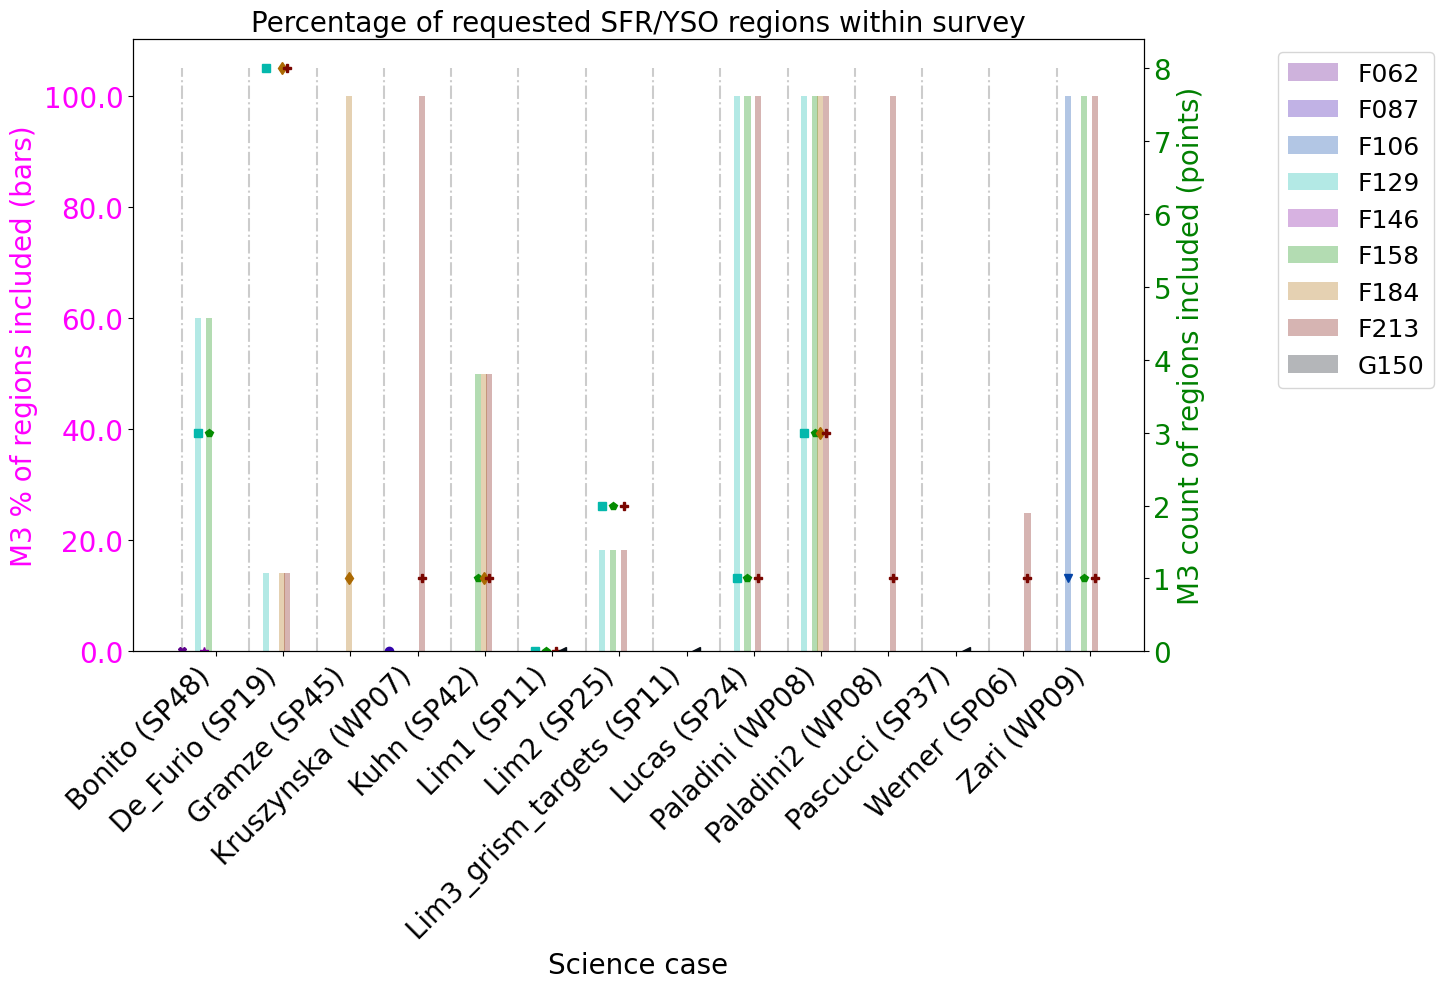

In [7]:
plot_name = 'm3_results_sfr_yso.png'
plot_m3_per_topic(m3_results, sfr_cases, sim_config, plot_name, plot_title='Percentage of requested SFR/YSO regions within survey')

In [8]:
cluster_cases = [
    author for author, info in science_cases.items() 
        if ('GC' in info['topics'] or 'OC' in info['topics']) and info['ready_for_use']
]
cluster_cases

['Kruszynska',
 'Lodieu2',
 'Hunt',
 'Lucas',
 'Globular_Clusters_catalog',
 'Open_Clusters_catalog',
 'Minniti_GCs']

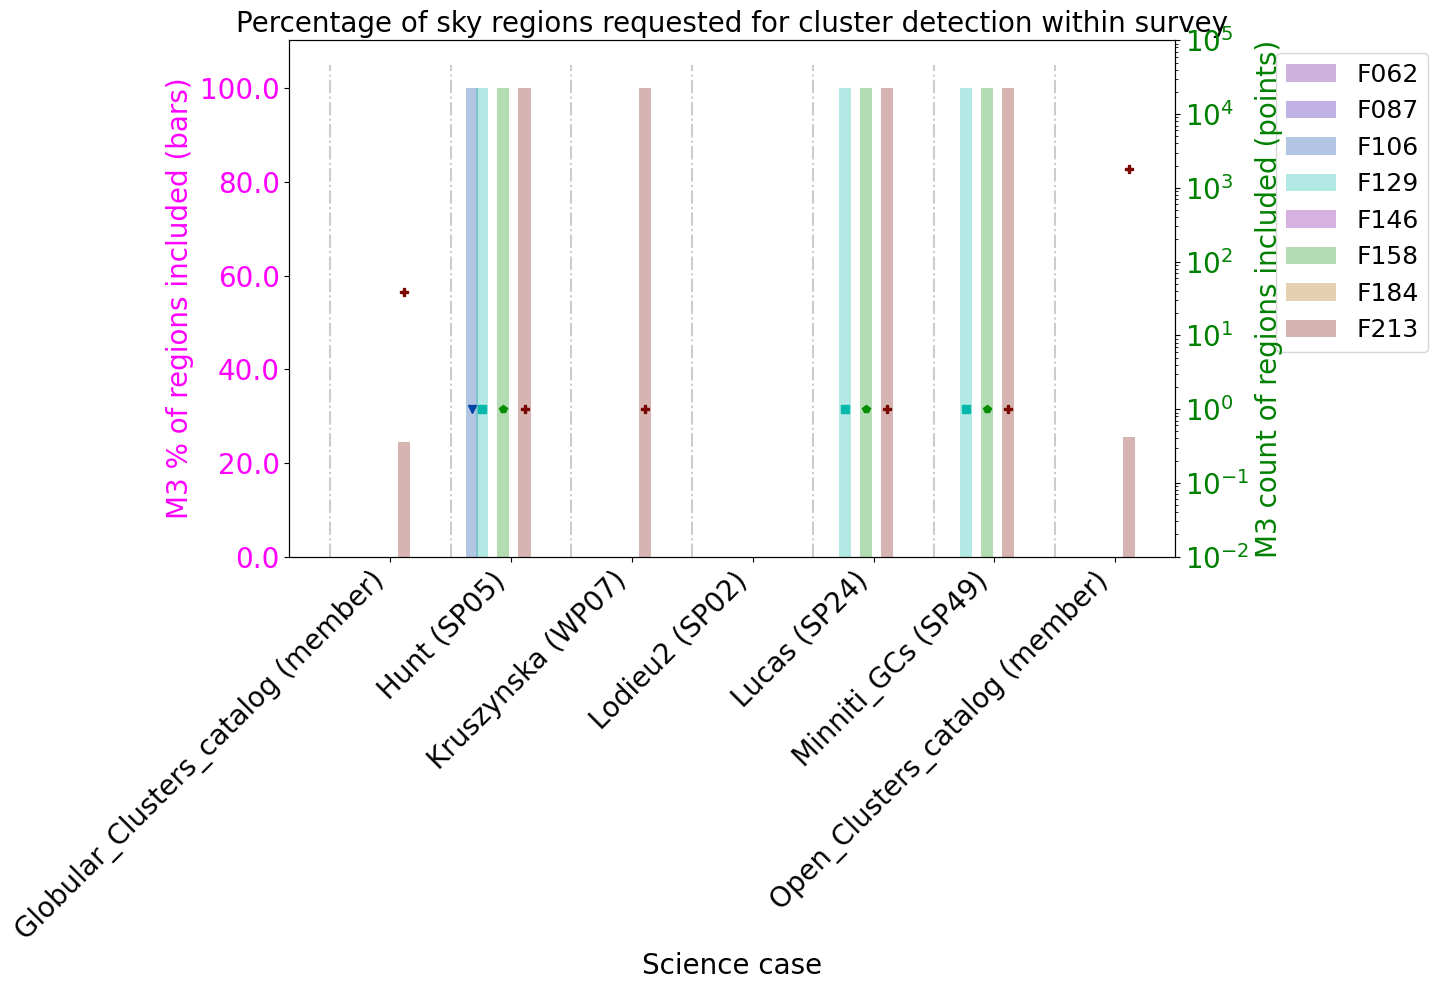

In [9]:
plot_name = 'm3_results_clusters.png'
plot_m3_per_topic(m3_results, cluster_cases, sim_config, plot_name, plot_title='Percentage of sky regions requested for cluster detection within survey')

Bearing in mind that this metric returns a percentage of the total sky area subtended by all objects in each catalog, these results cover a wide range.  However, many objects (e.g. SFRs) subtend large areas as seen from Earth, much of which is well outside the Galactic Plane and covered by other Roman surveys.  The percentage coverage for the Globular_Clusters and Open_Clusters catalogs should be interpreted with this in mind, since these include all known objects across the whole sky.  

Instead, some of the other science cases, such as Minniti2, recommended certain high priority clusters, so the coverage statistics in this case is more representative.  

In [10]:
# Load the survey regions
author = 'Lodieu2'
science_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_science_regions_'+author+'.json'))

In [11]:
survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

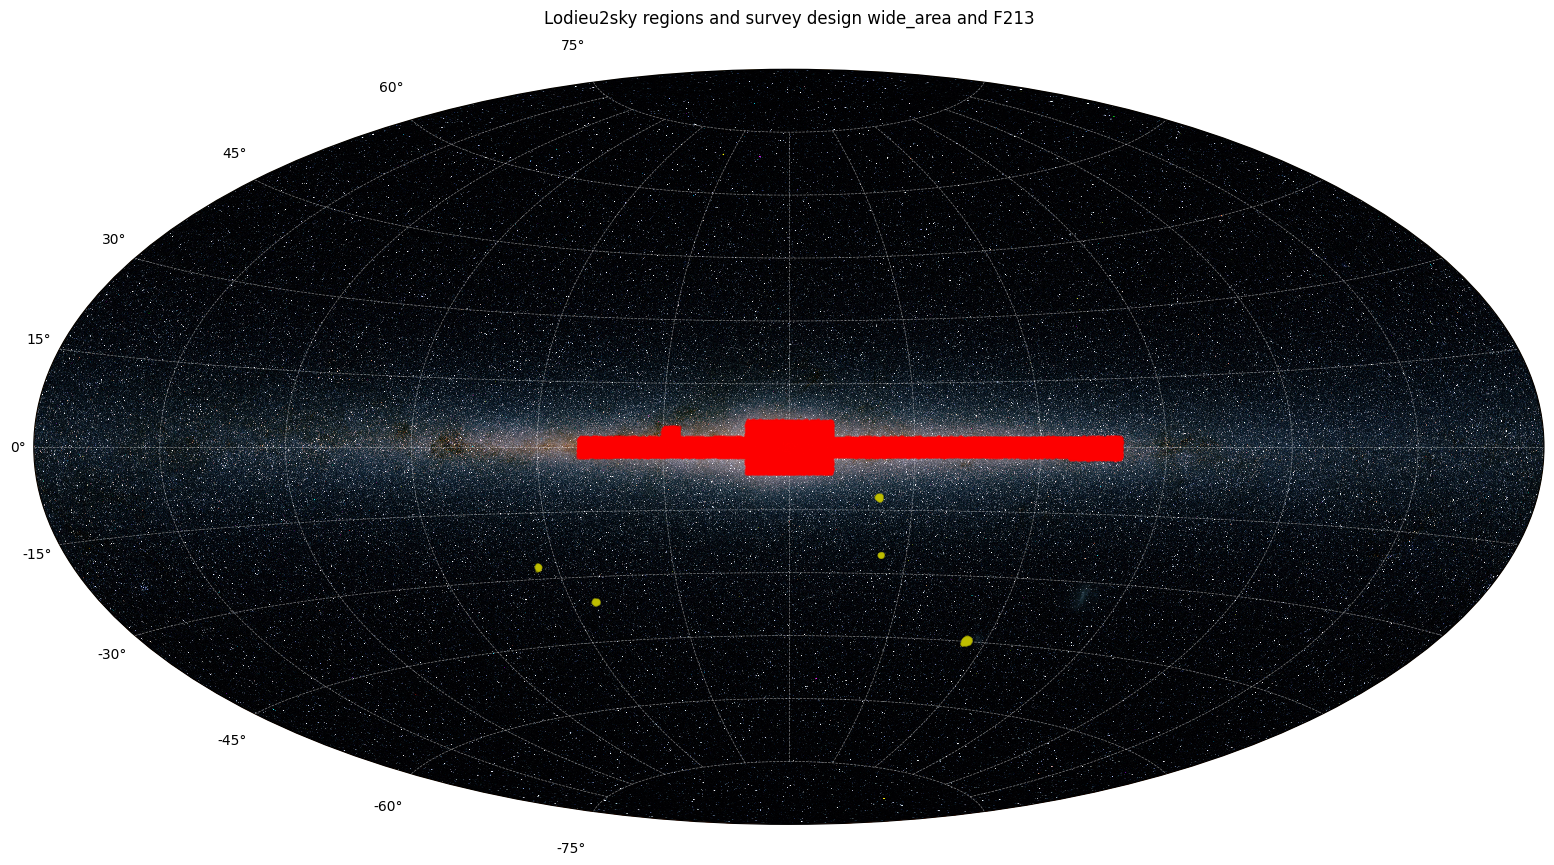

In [12]:
survey_option = 'wide_area' 
optic = 'F213' 

region_list = []
for f in sim_config['OPTICAL_COMPONENTS']:
    if f in science_regions[author].keys():
        for region in science_regions[author][f]:
            region_list.append(region)

r_merge = regions.combine_regions(region_list)

# Plot the combined science regions
plt.close()
mw2 = r_merge.sky_plot(
    title = author + 'sky regions and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.5
)

# Overplot the selected survey design
if len(survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        s = s.transform_to('icrs')
        mw2.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm3_results_skymap_gcs.png'))

## Tabulating the number of catalog targets included 

It is informative to review the overall numbers of known extended objects included within the survey footprint.  This can be compiled from the metric data by selecting the specific science cases that refer to large general catalogs of objects. 

In [13]:
general_catalogs = [
    'Open_Clusters_catalog', # Provide by Hunt
    'Globular_Clusters_catalog', # Baumgardt-Harris catalog
    'De_Furio', # SFR catalog 
    'DAmmando', # AGN
    'Villasenor', # Molecular Clouds
]
idx = [i for i,row in enumerate(m3_results) if row['Science_case'] in general_catalogs and row['Survey_strategy'] == 'wide_area']

case_results = m3_results[idx]
case_results

Survey_strategy,Optic,Science_case,Science_code,Category,M3_%regions,M3_count
str11,str4,str25,str10,str17,float64,int64
wide_area,F213,Open_Clusters_catalog,member,open_clusters,25.51974326775499,1829
wide_area,F129,De_Furio,SP19,SFR,14.035087719298245,8
wide_area,F184,De_Furio,SP19,SFR,14.035087719298245,8
wide_area,F213,De_Furio,SP19,SFR,14.035087719298245,8
wide_area,F184,DAmmando,SP12,AGN,5.896805896805897,24
wide_area,F213,Globular_Clusters_catalog,member,globular_clusters,24.528301886792452,39
wide_area,F062,Villasenor,SP15,molecular_clouds,0.0,0
wide_area,F129,Villasenor,SP15,molecular_clouds,56.81818181818182,25
wide_area,F213,Villasenor,SP15,molecular_clouds,56.81818181818182,25
